# Goal: Build a system to identify unreliable/fake news

Dataset used - https://www.kaggle.com/c/fake-news/data

Dataset Description
train.csv: A full training dataset with the following attributes:

id: unique id for a news article

title: the title of a news article

author: author of the news article

text: the text of the article; could be incomplete

label: a label that marks the article as potentially unreliable

1: unreliable

0: reliable

In [109]:
#Importing the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re #Regular expressions 
import nltk #Natural Language Toolkit
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
import itertools
import pickle

The Natural Language Toolkit (NLTK) is a platform used for building Python programs that work with human language data for applying in statistical natural language processing (NLP). It contains text processing libraries for tokenization, parsing, classification, stemming, tagging and semantic reasoning.

Stopwords are words which occur frequently in a corpus. e.g a, an, the, in. Frequently occurring words are removed from the corpus for the purpose of text-normalization.

In [110]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhask\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [111]:
# Printing the stopwords in English
# We will have to remove these from the corpus during our analysis and pre-processing
print(stopwords.words('english'))
print()
print('Total number of stopwords :',len(stopwords.words('english')))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [112]:
# Data Pre-processing and Analysis
# First let's load the dataset
news_dataset = pd.read_csv('train.csv')
print(news_dataset.shape)

(20800, 5)


In [113]:
# Checking for missing values
news_dataset.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [114]:
#Dropping the empty strings
news_dataset = news_dataset.dropna()
print(news_dataset.shape)

(18285, 5)


In [115]:
news_dataset.reset_index(inplace=True)

In [116]:
news_dataset.isnull().sum()

index     0
id        0
title     0
author    0
text      0
label     0
dtype: int64

In [ ]:
# We will use all text fields such as Title, Author & text description to train our model 
# to help predict if it is real or unreliable news
news_dataset['text_corpus'] = news_dataset['author']+' '+news_dataset['title']+' '+news_dataset['text']
print(news_dataset['text_corpus'])

In [ ]:
news_dataset.head()

In [11]:
# Now we will separate the data and label i.e. text_corpus and label fields
#X = news_dataset.drop(columns='label', axis=1)

#X = news_dataset['text_corpus']
#Y = news_dataset['label']

In [12]:
### Reading Test data
test_dataset = pd.read_csv('test.csv')
print(test_dataset.shape)

(5200, 4)


In [13]:
# Checking for missing values
test_dataset.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [14]:
#Dropping the empty strings
test_dataset = test_dataset.dropna()
print(test_dataset.shape)

(4575, 4)


In [15]:
test_dataset.reset_index(inplace=True)

In [16]:
test_dataset.isnull().sum()

index     0
id        0
title     0
author    0
text      0
dtype: int64

In [17]:
# We will use all text fields such as Title, Author & text description to test our model 
# to help predict if it is real or unreliable news
test_dataset['text_corpus'] = test_dataset['author']+' '+test_dataset['title']+' '+test_dataset['text']
print(test_dataset['text_corpus'])

0       David Streitfeld Specter of Trump Loosens Tong...
1       Common Dreams #NoDAPL: Native American Leaders...
2       Daniel Victor Tim Tebow Will Attempt Another C...
3       Truth Broadcast Network Keiser Report: Meme Wa...
4       Pam Key Pelosi Calls for FBI Investigation to ...
                              ...                        
4570    Pam Key Trump on If ’Tapes’ Exist of Comey Con...
4571    Jody Rosen The Bangladeshi Traffic Jam That Ne...
4572    Sheryl Gay Stolberg John Kasich Signs One Abor...
4573    Mike McPhate California Today: What, Exactly, ...
4574    Teddy Wayne Awkward Sex, Onscreen and Off - Th...
Name: text_corpus, Length: 4575, dtype: object


In [18]:
# Now we will separate the test_data and label i.e. text_corpus and label fields
#X_test = test_dataset.drop(columns='label', axis=1)

#X_test = test_dataset['text_corpus']
#Y_test = test_dataset['label']

## Remove Special Characters 

- Pick all alphabet characters - lowercase and uppercase...all others such as numbers and punctuations will be removed.
- Numbers or punctuations will be replaced by a whitespace

## Remove Stopwords

- Remove standard english stopwords

## Stemming or Lemmatization

- Here we will try to apply stemming - objective is to reduce the word to it's root word.
- For example: actor, actress, acting, action --> act

In [19]:
port_stem = PorterStemmer()

def stemming(content):
    # Pick all alphabet characters - lowercase and uppercase...all others such as numbers and punctuations will be removed. 
    #Numbers or punctuations will be replaced by a whitespace
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    # Converting all letters to lowercase 
    stemmed_content = stemmed_content.lower()
    # Converting all to a splitted case or a list
    stemmed_content = stemmed_content.split()
    # Applying stemming, so we get the root words wherever possible + remove stopwords as well
    stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    # Join all the words in final content
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [20]:
news_dataset['text_corpus'] = news_dataset['text_corpus'].apply(stemming)
print(news_dataset['text_corpus'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2        consortiumnew com truth might get fire truth m...
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
18280    jerom hudson rapper trump poster child white s...
18281    benjamin hoffman n f l playoff schedul matchup...
18282    michael j de la merc rachel abram maci said re...
18283    alex ansari nato russia hold parallel exercis ...
18284    david swanson keep f aliv david swanson author...
Name: text_corpus, Length: 18285, dtype: object


In [21]:
# Separating data and label from train data
X = news_dataset['text_corpus'].values
Y = news_dataset['label'].values

In [22]:
test_dataset['text_corpus'] = test_dataset['text_corpus'].apply(stemming)
print(test_dataset['text_corpus'])

0       david streitfeld specter trump loosen tongu pu...
1       common dream nodapl nativ american leader vow ...
2       daniel victor tim tebow attempt anoth comeback...
3       truth broadcast network keiser report meme war...
4       pam key pelosi call fbi investig find russian ...
                              ...                        
4570    pam key trump tape exist comey convers tell ma...
4571    jodi rosen bangladeshi traffic jam never end n...
4572    sheryl gay stolberg john kasich sign one abort...
4573    mike mcphate california today exactli sushi ne...
4574    teddi wayn awkward sex onscreen new york time ...
Name: text_corpus, Length: 4575, dtype: object


In [82]:
# Separating data and label
X_testt = test_dataset['text_corpus'].values

## TF-IDF (Term Frequency, Inverse Document Frequency) 

### Converting Textual data to Numerical data for Logistic regression

* We will use TF-IDF Vectorizer
* TF-IDF Vectorizer will convert textual data to numerical data

# Modeling & Model Evaluation without considering maximum feature in vectorizer object created above
### Training the model (model 1 : Logistic Regression)
### Training the model (model 2 : MultinomialNB Algorithm model)
### Training the model (model 3 : Passive Aggressive Classifier Algorithm)

In [106]:
#Initializing tfidf vectorizer without max_feature parametern for test data
vectorizer1 = TfidfVectorizer()
vectorizer1.fit(X_testt)

X_testtt = vectorizer1.transform(X_testt)
print(X_testtt)

  (0, 51791)	0.019152326101979433
  (0, 51680)	0.013603030914271537
  (0, 51602)	0.008162279160100842
  (0, 51296)	0.014696493264401263
  (0, 51226)	0.032458089231697226
  (0, 51208)	0.017963400900941756
  (0, 51202)	0.02470559365607444
  (0, 51194)	0.010943962334367946
  (0, 51189)	0.03051514157278351
  (0, 51182)	0.018451684190000348
  (0, 51177)	0.009817182081474198
  (0, 50787)	0.018595793749540915
  (0, 50778)	0.02834132947054698
  (0, 50730)	0.01501882894800817
  (0, 50609)	0.01915006050785553
  (0, 50529)	0.04413121927149239
  (0, 50485)	0.010879809682368338
  (0, 50401)	0.022254352266328443
  (0, 50378)	0.017835461435590554
  (0, 50311)	0.010150955280675859
  (0, 50230)	0.027049316943624484
  (0, 50156)	0.03047917251979877
  (0, 50099)	0.01644472974250758
  (0, 50091)	0.01752863373779727
  (0, 49813)	0.052060994659090136
  :	:
  (4574, 2040)	0.04205925278605167
  (4574, 1969)	0.022538127259348555
  (4574, 1895)	0.021896148127765858
  (4574, 1852)	0.04320059716336367
  (4574, 16

In [107]:
pickle.dump(vectorizer1, open('transform1.pkl', 'wb'))
tfidf1 = pickle.load(open('transform1.pkl', 'rb'))

In [108]:
vectorizer1.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [24]:
#Initializing tfidf vectorizer without max_feature parameter for train data
vectorizer = TfidfVectorizer()
vectorizer.fit(X)

X = vectorizer.transform(X)
print(X)

  (0, 103542)	0.04901434835330664
  (0, 103495)	0.01872577569795248
  (0, 102585)	0.04408585624372993
  (0, 102581)	0.09471806550886494
  (0, 102538)	0.0373955616362059
  (0, 102503)	0.011120618587639634
  (0, 101885)	0.017068661622212464
  (0, 101113)	0.016943168142829257
  (0, 101024)	0.012438945053558758
  (0, 100943)	0.02963752596590382
  (0, 100871)	0.012612127305072907
  (0, 100686)	0.011580772427573811
  (0, 99894)	0.02551891793554028
  (0, 99860)	0.0313803091232797
  (0, 98937)	0.021537726515811532
  (0, 97643)	0.06519465259133668
  (0, 96993)	0.033236200929305154
  (0, 96749)	0.01614637638746375
  (0, 96000)	0.037998720496489065
  (0, 95396)	0.01087634980891986
  (0, 95387)	0.04207735317609801
  (0, 95335)	0.13573175453703548
  (0, 95196)	0.07038333993030485
  (0, 93994)	0.03945123665577682
  (0, 93460)	0.026904266051021565
  :	:
  (18284, 7004)	0.010430773388291797
  (18284, 6696)	0.027700547220170835
  (18284, 6418)	0.03865017378349558
  (18284, 6380)	0.025275152200549454
  

In [99]:
pickle.dump(vectorizer, open('transform.pkl', 'wb'))
tfidf = pickle.load(open('transform.pkl', 'rb'))

In [26]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [27]:
### Splitting the data into test and train datasets for logistic regression
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.18, stratify=Y, random_state=124)

In [28]:
### Splitting the data into test and train datasets for MultinomialNB Algorithm model
X_train_nb, X_test_nb, Y_train_nb, Y_test_nb = train_test_split(X, Y, test_size=0.18, stratify=Y, random_state=124)

In [29]:
### Splitting the data into test and train datasets for Passive Aggressive Classifier Algorithm
X_train_pa, X_test_pa, Y_train_pa, Y_test_pa = train_test_split(X, Y, test_size=0.18, stratify=Y, random_state=124)

In [30]:
# Training the Logistic regression model
model1 = LogisticRegression()
model1.fit(X_train, Y_train)

LogisticRegression()

In [31]:
# Saving model to disk
pickle.dump(model1, open('model1.pkl','wb'))

# Loading model to compare the results
model1 = pickle.load(open('model1.pkl','rb'))

In [32]:
# Training the MultinomialNB Algorithm model
model2 = MultinomialNB()
model2.fit(X_train_nb, Y_train_nb)

MultinomialNB()

In [33]:
# Saving model to disk
pickle.dump(model2, open('model2.pkl','wb'))

# Loading model to compare the results
model2 = pickle.load(open('model2.pkl','rb'))

In [34]:
# Training the Passive Aggressive Classifier Algorithm
model3 = PassiveAggressiveClassifier()
model3.fit(X_train_pa, Y_train_pa)

PassiveAggressiveClassifier()

In [35]:
# Saving model to disk
pickle.dump(model3, open('model3.pkl','wb'))

# Loading model to compare the results
model3 = pickle.load(open('model3.pkl','rb'))

In [36]:
### Logistic regression Model Evaluation
# Accuracy Score on Training Data
X_train_prediction = model1.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

print('Accuracy score on the training data using logistic regression: ',training_data_accuracy)

# Accuracy Score on Test Data
X_test_prediction = model1.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

print('Accuracy score on the test data using logistic regression: ',test_data_accuracy)

Accuracy score on the training data using logistic regression:  0.9806576402321083
Accuracy score on the test data using logistic regression:  0.9623329283110571


In [37]:
### MultinomialNB Algorithm Model Evaluation
# Accuracy Score on Training Data
X_train_prediction_nb = model2.predict(X_train_nb)
training_data_accuracy_nb = accuracy_score(X_train_prediction_nb, Y_train_nb)

print('Accuracy score on the training data using MultinomialNB: ',training_data_accuracy_nb)

# Accuracy Score on Test Data
X_test_prediction_nb = model2.predict(X_test_nb)
test_data_accuracy_nb = accuracy_score(X_test_prediction_nb, Y_test_nb)

print('Accuracy score on the test data using MultinomialNB: ',test_data_accuracy_nb)

Accuracy score on the training data using MultinomialNB:  0.8278529980657641
Accuracy score on the test data using MultinomialNB:  0.7995139732685298


In [38]:
### Passive Aggressive Classifier Algorithm Model Evaluation
# Accuracy Score on Training Data
X_train_prediction_pa = model3.predict(X_train_pa)
training_data_accuracy_pa = accuracy_score(X_train_prediction_pa, Y_train_pa)

print('Accuracy score on the training data using Passive aggressive classifier: ',training_data_accuracy_pa)

# Accuracy Score on Test Data
X_test_prediction_pa = model3.predict(X_test_pa)
test_data_accuracy_pa = accuracy_score(X_test_prediction_pa, Y_test_pa)

print('Accuracy score on the test data using Passive aggressive classifier: ',test_data_accuracy_pa)

Accuracy score on the training data using Passive aggressive classifier:  1.0
Accuracy score on the test data using Passive aggressive classifier:  0.9760024301336574


In [39]:
# Function to plot confusion Matrix
def plot_confusion_matrix(cm, 
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Confusion matrix, without normalization


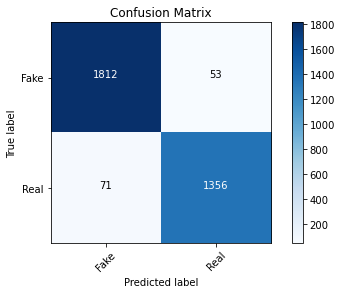

In [40]:
#Confusion matrix for logistic regression model
cm = metrics.confusion_matrix(Y_test, X_test_prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Confusion matrix, without normalization


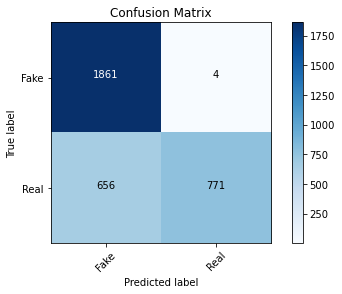

In [41]:
# Confusion matrix for MultinomialNB Algorithm Model
cm = metrics.confusion_matrix(Y_test_nb, X_test_prediction_nb)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Confusion matrix, without normalization


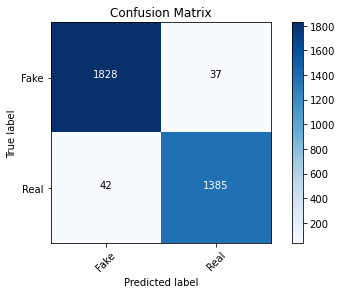

In [42]:
# Confusion matrix for Passive Aggressive Classifier Algorithm Model
cm = metrics.confusion_matrix(Y_test_pa, X_test_prediction_pa)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [43]:
# Classification report for test data in logistic regression
classification_report(Y_test, X_test_prediction)

'              precision    recall  f1-score   support\n\n           0       0.96      0.97      0.97      1865\n           1       0.96      0.95      0.96      1427\n\n    accuracy                           0.96      3292\n   macro avg       0.96      0.96      0.96      3292\nweighted avg       0.96      0.96      0.96      3292\n'

In [44]:
# Classification report for test data in MultinomialNB Algorithm Model
classification_report(Y_test_nb, X_test_prediction_nb)

'              precision    recall  f1-score   support\n\n           0       0.74      1.00      0.85      1865\n           1       0.99      0.54      0.70      1427\n\n    accuracy                           0.80      3292\n   macro avg       0.87      0.77      0.77      3292\nweighted avg       0.85      0.80      0.78      3292\n'

In [45]:
# Classification report for test data in Passive Aggressive Classifier Algorithm Model
classification_report(Y_test_pa, X_test_prediction_pa)

'              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98      1865\n           1       0.97      0.97      0.97      1427\n\n    accuracy                           0.98      3292\n   macro avg       0.98      0.98      0.98      3292\nweighted avg       0.98      0.98      0.98      3292\n'

In [91]:
X_test[100]

<1x105168 sparse matrix of type '<class 'numpy.float64'>'
	with 166 stored elements in Compressed Sparse Row format>

In [46]:
# Making a Prediction using logistic regression
X_new = X_test[100]

prediction = model1.predict(X_new)
print(prediction)

if (prediction[0] == 0):
  print('The news in Real')
else:
  print('The news is Fake and Unreliable')

[0]
The news in Real


In [47]:
# Making a Prediction using MultinomialNB Algorithm Model
X_new_nb = X_test_nb[100]

prediction_nb = model2.predict(X_new_nb)
print(prediction_nb)

if (prediction_nb[0] == 0):
  print('The news in Real')
else:
  print('The news is Fake and Unreliable')

[0]
The news in Real


In [48]:
# Making a Prediction using Passive Aggressive Classifier Algorithm Model
X_new_pa = X_test_pa[100]

prediction_pa = model3.predict(X_new_pa)
print(prediction_pa)

if (prediction_pa[0] == 0):
  print('The news in Real')
else:
  print('The news is Fake and Unreliable')

[0]
The news in Real


### Modeling & Model Evaluation with considering maximum feature(10000) in tfidf_v object created below
### Training the model (model 4 : MultinomialNB Algorithm)
### Training the model (model 5 : Passive Aggressive Classifier Algorithm)

In [49]:
# Separating data and label
X = news_dataset['text_corpus'].values
Y = news_dataset['label'].values

In [50]:
#Initializing tfidf vectorizer with max_feature=10000
tfidf_v = TfidfVectorizer(max_features=10000,ngram_range=(1,3))
X1 = tfidf_v.fit_transform(X).toarray()

In [51]:
X1.shape

(18285, 10000)

In [52]:
## Divide the dataset into Train and Test
X_train_, X_test_, y_train_, y_test_ = train_test_split(X1, Y, test_size=0.18, random_state=0)

In [53]:
#To check the top 200 feature name
tfidf_v.get_feature_names()[:200]

C:\Users\bhask\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aaron',
 'aaron klein',
 'abandon',
 'abba',
 'abbott',
 'abc',
 'abc news',
 'abduct',
 'abdullah',
 'abe',
 'abedin',
 'abid',
 'abil',
 'abl',
 'abl get',
 'aboard',
 'abolish',
 'aborigin',
 'abort',
 'abort right',
 'abraham',
 'abram',
 'abroad',
 'abruptli',
 'absenc',
 'absent',
 'absente',
 'absolut',
 'absorb',
 'abstract',
 'absurd',
 'abu',
 'abund',
 'abus',
 'academ',
 'academi',
 'academi award',
 'academia',
 'acceler',
 'accent',
 'accept',
 'access',
 'access pipelin',
 'accessori',
 'accid',
 'accident',
 'acclaim',
 'accommod',
 'accompani',
 'accomplish',
 'accord',
 'accord mr',
 'accord new',
 'accord one',
 'accord peopl',
 'accord report',
 'accord two',
 'accordingli',
 'account',
 'accumul',
 'accur',
 'accuraci',
 'accus',
 'accus mr',
 'accustom',
 'achiev',
 'acid',
 'acknowledg',
 'aclu',
 'acosta',
 'acquir',
 'acquisit',
 'acquit',
 'acr',
 'across',
 'across america',
 'across border',
 'across countri',
 'across nation',
 'across state',
 'act',
 'a

In [54]:
#Get the parameters details
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 10000,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [55]:
count_df = pd.DataFrame(X_train_, columns=tfidf_v.get_feature_names())
count_df.head()

,aaron,aaron klein,abandon,abba,abbott,abc,abc news,abduct,abdullah,abe,...,zero,zero hedg,zika,zika viru,zionist,zone,zone syria,zoo,zu,zuckerberg
0,0.0,0.0,0.0464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.095961,0.0
2,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.366983,0.059606,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [56]:
# Training the model
model4 = MultinomialNB()
model4.fit(X_train_, y_train_)

MultinomialNB()

In [57]:
### Model Evaluation
# Accuracy Score on Training Data
X_train_prediction_ = model4.predict(X_train_)
training_data_accuracy_ = accuracy_score(X_train_prediction_, y_train_)

print('Accuracy score on the training data: ',training_data_accuracy_)

# Accuracy Score on Test Data
X_test_prediction_ = model4.predict(X_test_)
test_data_accuracy_ = accuracy_score(X_test_prediction_, y_test_)

print('Accuracy score on the test data: ',test_data_accuracy_)

Accuracy score on the training data:  0.9359701193890482
Accuracy score on the test data:  0.9286148238153098


In [58]:
y_train_.shape

(14993,)

Confusion matrix, without normalization


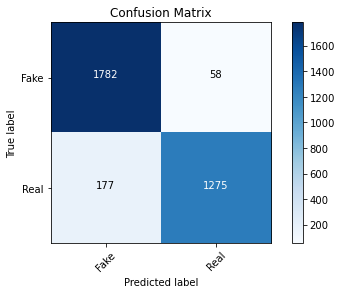

In [59]:
cm = metrics.confusion_matrix(y_test_, X_test_prediction_)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [60]:
# Classification report for test data
classification_report(y_test_, X_test_prediction_)

'              precision    recall  f1-score   support\n\n           0       0.91      0.97      0.94      1840\n           1       0.96      0.88      0.92      1452\n\n    accuracy                           0.93      3292\n   macro avg       0.93      0.92      0.93      3292\nweighted avg       0.93      0.93      0.93      3292\n'

### Passive Aggressive Classifier Algorithm

In [61]:
## Divide the dataset into Train and Test
X_train5, X_test5, y_train5, y_test5 = train_test_split(X1, Y, test_size=0.18, random_state=0)

In [62]:
model5 = PassiveAggressiveClassifier()
model5.fit(X_train5, y_train5)

PassiveAggressiveClassifier()

In [63]:
### Model Evaluation
# Accuracy Score on Training Data
X_train_prediction5 = model5.predict(X_train5)
training_data_accuracy5 = accuracy_score(X_train_prediction5, y_train5)

print('Accuracy score on the training data: ',training_data_accuracy5)

# Accuracy Score on Test Data
X_test_prediction5 = model5.predict(X_test5)
test_data_accuracy5 = accuracy_score(X_test_prediction5, y_test5)

print('Accuracy score on the test data: ',test_data_accuracy5)

Accuracy score on the training data:  1.0
Accuracy score on the test data:  0.9723572296476306


In [64]:
y_train5.shape

(14993,)

Confusion matrix, without normalization


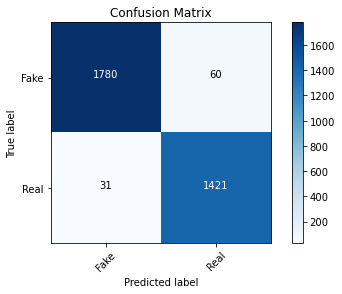

In [65]:
cm = metrics.confusion_matrix(y_test5, X_test_prediction5)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [66]:
# Classification report for test data
classification_report(y_test_, X_test_prediction_)

'              precision    recall  f1-score   support\n\n           0       0.91      0.97      0.94      1840\n           1       0.96      0.88      0.92      1452\n\n    accuracy                           0.93      3292\n   macro avg       0.93      0.92      0.93      3292\nweighted avg       0.93      0.93      0.93      3292\n'

### Hyper parameter tuning for Multinomial Classifier

In [67]:
classifier=MultinomialNB(alpha=0.1)

In [68]:
previous_score=0
for alpha in np.arange(0,1,0.1):
    sub_classifier=MultinomialNB(alpha=alpha)
    sub_classifier.fit(X_train_,y_train_)
    y_pred=sub_classifier.predict(X_test_)
    score = metrics.accuracy_score(y_test_, X_test_prediction_)
    if score>previous_score:
        classifier=sub_classifier
    print("Alpha: {}, Score : {}".format(alpha,score))

C:\Users\bhask\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Alpha: 0.0, Score : 0.9286148238153098
Alpha: 0.1, Score : 0.9286148238153098
Alpha: 0.2, Score : 0.9286148238153098
Alpha: 0.30000000000000004, Score : 0.9286148238153098
Alpha: 0.4, Score : 0.9286148238153098
Alpha: 0.5, Score : 0.9286148238153098
Alpha: 0.6000000000000001, Score : 0.9286148238153098
Alpha: 0.7000000000000001, Score : 0.9286148238153098
Alpha: 0.8, Score : 0.9286148238153098
Alpha: 0.9, Score : 0.9286148238153098


In [69]:
## Get Features names
feature_names = tfidf_v.get_feature_names()

C:\Users\bhask\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [70]:
### Most real
sorted(zip(classifier.coef_[0], feature_names), reverse=True)[:20]

C:\Users\bhask\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


[(-5.562359555775333, 'clinton'),
 (-5.647768034131754, 'trump'),
 (-5.822517879227114, 'hillari'),
 (-6.118475072705672, 'elect'),
 (-6.145067131972924, 'us'),
 (-6.347583330033277, 'vote'),
 (-6.3778070414090875, 'peopl'),
 (-6.402902037665024, 'email'),
 (-6.4071570751744975, 'state'),
 (-6.454905620985296, 'fbi'),
 (-6.462136077434587, 'one'),
 (-6.491542924213137, 'hillari clinton'),
 (-6.515536807492816, 'war'),
 (-6.550861962267366, 'would'),
 (-6.564110696816847, 'world'),
 (-6.568131755858986, 'like'),
 (-6.582607860447473, 'american'),
 (-6.6637878450534584, 'presid'),
 (-6.6724168562472315, 'russia'),
 (-6.679406040960709, 'year')]

In [71]:
### Most fake words
sorted(zip(classifier.coef_[0], feature_names))[:20]

[(-11.292853150530071, 'accord mr'),
 (-11.292853150530071, 'advis mr'),
 (-11.292853150530071, 'ago mr'),
 (-11.292853150530071, 'airbag'),
 (-11.292853150530071, 'also polit analyst'),
 (-11.292853150530071, 'amend columnist'),
 (-11.292853150530071, 'amend columnist breitbart'),
 (-11.292853150530071, 'american radio follow'),
 (-11.292853150530071, 'analyst arm'),
 (-11.292853150530071, 'analyst arm american'),
 (-11.292853150530071, 'antidop'),
 (-11.292853150530071, 'arm american radio'),
 (-11.292853150530071, 'attorney gener jeff'),
 (-11.292853150530071, 'author igcolonel'),
 (-11.292853150530071, 'author igcolonel hotmail'),
 (-11.292853150530071, 'avail regneri'),
 (-11.292853150530071, 'awr'),
 (-11.292853150530071, 'awr hawkin'),
 (-11.292853150530071, 'awr hawkin breitbart'),
 (-11.292853150530071, 'awr hawkin second')]

# HashingVectorizer

In [72]:
#Initializing Hashing vectorizer with maximum feature as 10000
hs_vectorizer=HashingVectorizer(n_features=10000)
X2=hs_vectorizer.fit_transform(X).toarray()

In [73]:
X2.shape

(18285, 10000)

In [74]:
## Divide the dataset into Train and Test
from sklearn.model_selection import train_test_split
X_train_hv, X_test_hv, y_train_hv, y_test_hv = train_test_split(X2, Y, test_size=0.18, random_state=0)

In [75]:
# Training the Logistic regression model
model6 = LogisticRegression()
model6.fit(X_train_hv, y_train_hv)

LogisticRegression()

In [76]:
### Model Evaluation
# Accuracy Score on Training Data
X_train_prediction6 = model6.predict(X_train_hv)
training_data_accuracy6 = accuracy_score(X_train_prediction6, y_train_hv)

print('Accuracy score on the training data: ',training_data_accuracy6)

# Accuracy Score on Test Data
X_test_prediction6 = model6.predict(X_test_hv)
test_data_accuracy6 = accuracy_score(X_test_prediction6, y_test_hv)

print('Accuracy score on the test data: ',test_data_accuracy6)

Accuracy score on the training data:  0.9671179883945842
Accuracy score on the test data:  0.948359659781288


In [77]:
y_train5.shape

(14993,)

Confusion matrix, without normalization


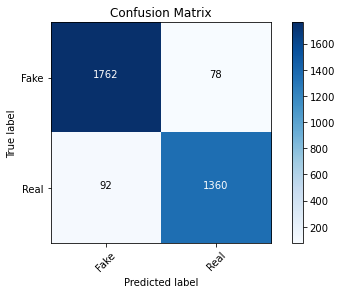

In [78]:
cm = metrics.confusion_matrix(y_test_hv, X_test_prediction6)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [79]:
# Classification report for test data
classification_report(y_test_hv, X_test_prediction6)

'              precision    recall  f1-score   support\n\n           0       0.95      0.96      0.95      1840\n           1       0.95      0.94      0.94      1452\n\n    accuracy                           0.95      3292\n   macro avg       0.95      0.95      0.95      3292\nweighted avg       0.95      0.95      0.95      3292\n'